In [1]:
from huggingface_hub import HfApi
import math
!huggingface-cli login --token hf_lxxxx
def get_folder_subset(repo_id, start_percent, end_percent, repo_type="dataset"):
    api = HfApi()

    # List the contents of the repository
    repo_contents = api.list_repo_files(repo_id, repo_type=repo_type)

    # Filter for files inside the "data" directory
    data_contents = [file for file in repo_contents if file.startswith("data/")]

    # Get unique folders inside "data"
    folders_in_data = sorted(set(file.split('/')[1] for file in data_contents if file.count('/') > 1))
    
    total_folders = len(folders_in_data)
    start_index = math.floor(total_folders * start_percent / 100)
    end_index = math.floor(total_folders * end_percent / 100)

    selected_folders = folders_in_data[start_index:end_index]

    print(f"Total folders: {total_folders}")
    print(f"Selected folders ({start_percent}% - {end_percent}%): {len(selected_folders)}")
    print("Folders:", ', '.join(selected_folders))

    # Return files from selected folders
    selected_files = [file for file in data_contents if file.split('/')[1] in selected_folders]
    return selected_files

# Replace with the actual repo_id
repo_id = "litagin/moe-speech"

# Example usage:
# First 25%
first_quarter = get_folder_subset(repo_id, 0, 25)

# # Second 25%
# second_quarter = get_folder_subset(repo_id, 25, 50)

# # Third 25%
# third_quarter = get_folder_subset(repo_id, 50, 75)

# # Last 25%
# last_quarter = get_folder_subset(repo_id, 75, 100)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/austin/.cache/huggingface/token
Login successful
Total folders: 473
Selected folders (0% - 25%): 118
Folders: 00013899, 00163dc9, 010b4e02, 012e4f22, 01a5575c, 02153faa, 0253acb6, 02d30f40, 034aea85, 03d42201, 047b2cc9, 04dfddf9, 05a45f91, 05b1a5fa, 066d5771, 06d63234, 074a35a1, 07afb6cf, 07ec6abd, 082dc264, 0850f695, 0a4a9528, 0a9523ac, 0ab8878d, 0ac15611, 0b8ae160, 0c109d26, 0ccb413a, 0d70cf5c, 0da07cfa, 0deadde0, 0e1e679f, 0ee82b61, 0f6fbea8, 10fe64fb, 1105cfcb, 11858a03, 11b1eb07, 13383861, 13478d0f, 14ac96ed, 14e8c9ac, 16fefdd2, 1707f3b6, 17184d5e, 17989c6c, 18460462, 18563891, 1967ee53, 1a32de6a, 1a5a3db8, 1b74d271, 1ba0d17b, 1cc3c6c0, 1ceb61c1, 1dbea640, 1ed99743, 1fb0665c, 20b5dff7, 20

In [3]:
import io
import sys
import time
import threading
from IPython import get_ipython

def start_logging(log_file_path='cell_output.log', interval=5):
    # Create a custom output stream
    class LogStream(io.StringIO):
        def __init__(self, filename):
            super().__init__()
            self.filename = filename
        
        def write(self, text):
            super().write(text)
            with open(self.filename, 'a') as f:
                f.write(text)

    # Create the log stream
    log_stream = LogStream(log_file_path)

    # Redirect stdout and stderr to the log stream
    sys.stdout = log_stream
    sys.stderr = log_stream

    # Function to save the current output
    def save_output():
        while True:
            time.sleep(interval)
            log_stream.flush()

    # Start the logging in a separate thread
    logging_thread = threading.Thread(target=save_output, daemon=True)
    logging_thread.start()

    print(f"Logging started. Output will be saved to {log_file_path} every {interval} seconds.")

# Start logging
start_logging()

In [ ]:
from huggingface_hub import hf_hub_download
from tqdm import tqdm
import os
import time

def download_dataset(repo_id, local_dir, file_list, num_retries=10, retry_interval=15):
    # Check if the files are already downloaded
    downloaded_files = []
    for root, _, files in os.walk(local_dir):
        for file in files:
            downloaded_files.append(os.path.relpath(os.path.join(root, file), local_dir))

    # Download files
    for file_path in tqdm(file_list):
        local_file_path = os.path.join(local_dir, file_path)
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

        # Check if the file is already downloaded
        if file_path in downloaded_files:
            print(f"Skipping already downloaded file: {file_path}")
            continue

        # Retry download
        for retry_count in range(num_retries):
            try:
                # Download the file
                hf_hub_download(
                    repo_id=repo_id,
                    filename=file_path,
                    repo_type="dataset",
                    local_dir=local_dir,
                    local_dir_use_symlinks=False
                )
                print(f"Successfully downloaded: {file_path}")
                break  # Exit the loop if download is successful
            except Exception as e:
                print(f"Error downloading {file_path}. Retrying in {retry_interval} seconds... ({retry_count+1}/{num_retries})")
                if retry_count == num_retries - 1:
                    print(f"Failed to download {file_path} after {num_retries} attempts.")
                else:
                    time.sleep(retry_interval)

# Usage
repo_id = "litagin/moe-speech"
local_dir = "/home/austin/disk2/llmvcs/tt/stylekan/Data/"


download_dataset(repo_id, local_dir, first_quarter)

In [18]:
import pandas as pd
import os

# Load the dataset
file_path = "/home/austin/disk2/llmvcs/tt/stylekan/Data/train_List_updated.csv"
df = pd.read_csv(file_path, sep='|', header=None)

# Assuming the first column contains the paths
audio_paths = df.iloc[:, 0]

# Check if each path exists
valid_paths = []
invalid_paths = []

for path in audio_paths:
    if os.path.exists(path):
        valid_paths.append(path)
    else:
        invalid_paths.append(path)

# Print the results
print(f"Total paths checked: {len(audio_paths)}")
print(f"Valid paths: {len(valid_paths)}")
print(f"Invalid paths: {len(invalid_paths)}")

# Optionally, print the invalid paths for further inspection
if invalid_paths:
    print("\nInvalid paths:")
    for invalid_path in invalid_paths:
        print(invalid_path)

Total paths checked: 525530
Valid paths: 525530
Invalid paths: 0


In [1]:
from pytorch_lightning.loggers import LightningLoggerBase

In [7]:
from IPython.display import Audio
Audio("/home/austin/disk2/llmvcs/tt/stylekan/Data/moe_sp/data/3ec57102/wav/3ec57102_137.wav")

In [11]:
import pandas as pd

# Load the dataset
file_path = "/home/austin/disk1/stts-zs_cleaning/data/filename.csv"
df = pd.read_csv(file_path, sep='|', header=None)
# df = df.sample(frac=1)
df.shape

(118592, 2)

In [9]:
import os
import shutil
from tqdm import tqdm
# Define the source and destination directories
source_dir = "/home/austin/disk1/stts-zs_cleaning/data/reconstructer_set/valid/noisy"
destination_dir = "/home/austin/disk1/stts-zs_cleaning/MP-SENet/VoiceBank+DEMAND/wavs_noisy"

# Ensure the destination directory exists, if not, create it
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Get a list of all files in the source directory
files = os.listdir(source_dir)

# Move each file from the source directory to the destination directory
for file_name in tqdm(files):
    # Construct full file path
    source_file = os.path.join(source_dir, file_name)
    destination_file = os.path.join(destination_dir, file_name)
    
    # Move the file
    shutil.move(source_file, destination_file)


print("All files have been moved successfully.")

100%|██████████| 101/101 [00:00<00:00, 16215.92it/s]

All files have been moved successfully.


In [7]:
df.to_csv(file_path, index=False, header=False, sep="|")

In [15]:
import pandas as pd

replacements = {
    '/home/austin/disk2/llmvcs/tt/stylekan/Data/moe_res/fumika': '/home/austin/disk2/llmvcs/tt/stylekan/Data/moe_res/imas_split/fumika',

}

df[0] = df[0].replace(replacements, regex=True)


output_file_path = "/home/austin/disk2/llmvcs/tt/stylekan/Data/train_List_updated.csv"
df.to_csv(output_file_path, sep='|', header=False, index=False)

print(df.shape)

Updated dataset saved to: (525530, 3)


In [11]:
df_val = df.sample(frac=0.0025)
print('val -> ', df_val.shape)

df_train = df[~df.index.isin(df_val.index)]
df_train.shape

val ->  (131, 3)


(52323, 3)

In [10]:
top_10_values = df_[2].value_counts().nlargest(35).index


df_ = df_[df_[2].isin(top_10_values)]


df_.shape

(92971, 4)

In [16]:
import pandas as pd

# Load the dataset
file_path = "/home/austin/disk2/llmvcs/tt/stylekan/Data/metadata_cleanest/FT_imas_remapped.csv"
df = pd.read_csv(file_path, sep='|', header=None)
df.shape

(52454, 3)

In [20]:
import pandas as pd

# path_prefix_1 = "/home/austin/disk2/llmvcs/tt/stylekan/Data/moe_res/imas_split/shiki/shiki_fine"
path_prefix_2 = "/home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/001/"
path_prefix_3 = "/home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/saori"
path_prefix_6 = "/home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/01/"
path_prefix_4 = "/home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split"
path_prefix_5 = "/home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/011/"

# Filter the DataFrame to keep only the rows with the specified path prefixes
df = df[df[0].str.startswith(path_prefix_2) | df[0].str.startswith(path_prefix_3) | df[0].str.startswith(path_prefix_4) | df[0].str.startswith(path_prefix_5) | df[0].str.startswith(path_prefix_6)]
df.shape

(59297, 4)

In [48]:
df_train = pd.read_csv("/home/austin/disk2/llmvcs/tt/stylekan/Data/metadata_cleanest/FT_imas_valid.csv", header=None, sep="|")
df_train = df_train.drop(0, axis=1)
df_train.head()

1  \
0  /home/austin/disk2/llmvcs/tt/stylekan/Data/moe...   
1  /home/austin/disk2/llmvcs/tt/stylekan/Data/moe...   
2  /home/austin/disk2/llmvcs/tt/stylekan/Data/moe...   
3  /home/austin/disk2/llmvcs/tt/stylekan/Data/moe...   
4  /home/austin/disk2/llmvcs/tt/stylekan/Data/moe...   

                                                   2    3  
0  jakei ga...kiɽabijaka na sekai ga, ɯɽajamaɕiː ...  490  
1                        bɯdʑi ka naː—? doɯ ka daː—?  480  
2  maːmaː, aʔtakakaʔta ka naː. samɯi dake dʑa nai...  498  
3  ima wa ɕiʔsoɯ sɯrɯ kibɯɴ dʑa nai ka naː. basɯ ...  480  
4                      toʔte kɯɽerɯ? pɯɽodʲɯɯsaːsaɴ.  482

In [13]:
df_train.to_csv("/home/austin/disk2/llmvcs/tt/stylekan/Data/metadata_cleanest/FT_imas.csv", sep="|", header=False, index=False)

In [25]:
import pandas as pd
import librosa
import os

# Define the path to the CSV file
csv_path = '/home/austin/disk2/llmvcs/tt/stylekan/Data/metadata_cleanest/FT_imas_valid.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path, sep='|', header=None)

# Function to get the duration of an audio file in seconds
def get_audio_duration(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        return duration
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Filter out rows where the audio duration is longer than 18 seconds
filtered_df = df[df.apply(lambda row: get_audio_duration(row[0]) > 10 if pd.notna(row[0]) else False, axis=1)]

# Save the filtered DataFrame back to a CSV file
filtered_df.to_csv('/home/austin/disk2/llmvcs/tt/stylekan/Data/metadata_cleanest/FT_imas_valid_more_than_10sec.csv', sep='|', header=False, index=False)

filtered_df.shape

(17, 3)

In [2]:
# Load the dataset
import pandas as pd
file_path = "/home/austin/disk1/stts-zs_cleaning/data/puckysamples_subset.csv"
df = pd.read_csv(file_path, sep='|', header=None)
df.shape

(59297, 4)

In [76]:
import librosa
import torch
import numpy as np
import torchaudio
sample_paths = ['/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/samps/01008270.wav',
            '/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/samps/syuukovoice_200918_3_01.wav',
            # '/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/samps/nande.wav',
            '/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/samps/01-DDDP2.wav']

def valid(paths):

    dire = "/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/samps/24khz_fucky/"
    for path in paths:
        name = path.split('/')[-1][:-4]
        y, s = librosa.load(path, sr=48000)
        
        augment = Compose([
            # BitCrush(p=1., min_bit_depth=3,max_bit_depth=4),
            Mp3Compression(p=1, min_bitrate=24, max_bitrate=24)
        ])

        

        
        # downsampled_audio = y
        downsampled_audio = librosa.resample(y, orig_sr=48000, target_sr=24000)
        s= 24000
        downsampled_audio = augment(samples=downsampled_audio, sample_rate=s)
        # downsampled_audio = librosa.resample(downsampled_audio, orig_sr=16000, target_sr=48000)
        

        downsampled_audio = torch.tensor(downsampled_audio).to('cpu')
        
        # noise = torch.randn_like(downsampled_audio)
        # if np.random.rand() < 1.:
        #     downsampled_audio += noise * 0.1
        # else:
        #     downsampled_audio = downsampled_audio
        
        # downsampled_audio = downsampled_audio[:2**18]
        downsampled_audio = downsampled_audio.unsqueeze(0).unsqueeze(0)


        # sample = model.sample(downsampled_audio, num_steps=50)

        torchaudio.save(f'{dire}_{name}_original.wav', downsampled_audio[0].cpu(), 24000)
        
valid(sample_paths)

In [114]:
from audiomentations import *
import numpy as np
import librosa
from IPython.display import Audio as ad

# Load the audio file
audio, sr = librosa.load("/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/samps/syuukovoice_200918_3_01.wav", sr=48000)

audio = librosa.resample(audio, orig_sr=sr, target_sr=24000)
sr = 24000
# Define the augmentation pipeline
augment = Compose([
    # BitCrush(p=1., min_bit_depth=3,max_bit_depth=4),
    Mp3Compression(p=1, min_bitrate=16, max_bitrate=24)
])

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=audio, sample_rate=sr)

# Play the augmented audio (assuming `ad` is a function to play audio)
ad(augmented_samples, rate=sr)

In [2]:
import os
import pandas as pd
import shutil
# Define the input and output directories
input_file = '/home/austin/disk1/stts-zs_cleaning/data/puckysamples_subset.csv'
output_dir = '/home/austin/disk1/stts-zs_cleaning/data/reconstructer_set'

# Create the necessary subdirectories
train_clean_dir = os.path.join(output_dir, 'train', 'clean')
train_noisy_dir = os.path.join(output_dir, 'train', 'noisy')
valid_clean_dir = os.path.join(output_dir, 'valid', 'clean')
valid_noisy_dir = os.path.join(output_dir, 'valid', 'noisy')

os.makedirs(train_clean_dir, exist_ok=True)
os.makedirs(train_noisy_dir, exist_ok=True)
os.makedirs(valid_clean_dir, exist_ok=True)
os.makedirs(valid_noisy_dir, exist_ok=True)

# Load the input data using Pandas
data = pd.read_csv(input_file, sep='|', header=None)

# Split the data into training and validation sets
train_size = int(len(data) * 0.998)
data_train = data.iloc[:train_size]
data_valid = data.iloc[train_size:]

# Copy the files to the appropriate directories
for _, row in data_train.iterrows():
    clean_path, noisy_path = row[0], row[1]
    
    # Copy the clean audio file
    clean_filename = os.path.basename(clean_path)
    clean_output_path = os.path.join(train_clean_dir, clean_filename)
    shutil.copy(clean_path, clean_output_path)
    
    # Copy the noisy audio file
    noisy_filename = os.path.basename(noisy_path)
    noisy_output_path = os.path.join(train_noisy_dir, noisy_filename)
    shutil.copy(noisy_path, noisy_output_path)

for _, row in data_valid.iterrows():
    clean_path, noisy_path = row[0], row[1]
    
    # Copy the clean audio file
    clean_filename = os.path.basename(clean_path)
    clean_output_path = os.path.join(valid_clean_dir, clean_filename)
    shutil.copy(clean_path, clean_output_path)
    
    # Copy the noisy audio file
    noisy_filename = os.path.basename(noisy_path)
    noisy_output_path = os.path.join(valid_noisy_dir, noisy_filename)
    shutil.copy(noisy_path, noisy_output_path)

print('Data preparation complete!')

Data preparation complete!


In [2]:
import os
import shutil
from tqdm import tqdm
# Define the paths
source_file = "/home/austin/disk2/llmvcs/tt/deepfilter/valid_set_speech.txt"
search_dir = "/home/austin/disk1/stts-zs_cleaning/data"
target_dir = "/home/austin/disk2/llmvcs/tt/deepfilter/valid_speech"

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Read the file paths from the source file
with open(source_file, 'r') as file:
    file_paths = file.readlines()

# Extract file names from the file paths
file_names = [os.path.basename(path.strip()) for path in file_paths]

# Search for the files in the search directory and its subdirectories
for root, dirs, files in os.walk(search_dir):
    for file_name in tqdm(file_names):
        if file_name in files:
            source_path = os.path.join(root, file_name)
            target_path = os.path.join(target_dir, file_name)
            # Copy the file to the target directory
            shutil.copy2(source_path, target_path)
            print(f"Copied {source_path} to {target_path}")

print("Copying completed.")

100%|██████████| 212/212 [00:00<00:00, 51838.89it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/shiburin/shiburin_mobamas/shiburin_mobamasu_0017/shiburin_mobamasu_0017_chunk75.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/shiburin_mobamasu_0017_chunk75.wav


100%|██████████| 212/212 [00:00<00:00, 66007.90it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/shiburin/shiburin_mobamas/shiburin_mobamasu_0015/shiburin_mobamasu_0015_chunk147.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/shiburin_mobamasu_0015_chunk147.wav


100%|██████████| 212/212 [00:00<00:00, 92972.86it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Kanade/Kanade_voice_home_shinaido_room/kanade_card_200761/kanade_voice_200761_4_02.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/kanade_voice_200761_4_02.wav


100%|██████████| 212/212 [00:00<00:00, 81802.43it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Kanade/Kanade_voice_home_shinaido_room/kanade_card_200645/kanade_voice_200645_1_07.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/kanade_voice_200645_1_07.wav


100%|██████████| 212/212 [00:00<00:00, 107247.91it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Kanade/Kanade_voice_home_shinaido_room/kanade_card_200459/kanade_voice_200459_2_06.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/kanade_voice_200459_2_06.wav


100%|██████████| 212/212 [00:00<00:00, 283905.63it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Kanade/mobamas_voices/Serifu/voices_kanade_idealist_plus/voices_kanade_idealist_plus_chunk1.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/voices_kanade_idealist_plus_chunk1.wav


100%|██████████| 212/212 [00:00<00:00, 121924.10it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Kanade/Kanade_Events_and_Card/Kanade_Events/MainComyu_Kanade/MainComyu_Kanade_chunk93.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/MainComyu_Kanade_chunk93.wav


100%|██████████| 212/212 [00:00<00:00, 206022.35it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Kanade/Kanade_Events_and_Card/Kanade_Events/NBK/NBK_chunk21.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/NBK_chunk21.wav


100%|██████████| 212/212 [00:00<00:00, 181950.57it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Kanade/Kanade_Events_and_Card/Kanade_Events/prettyliar/prettyliar_chunk172.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/prettyliar_chunk172.wav


100%|██████████| 212/212 [00:00<00:00, 144443.22it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mayu/mayu_mobamas/mayu_mobamasu_0013/mayu_mobamasu_0013_chunk188.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mayu_mobamasu_0013_chunk188.wav


100%|██████████| 212/212 [00:00<00:00, 148272.88it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mayu/mayu_mobamas/mayu_mobamasu_0012/mayu_mobamasu_0012_chunk116.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mayu_mobamasu_0012_chunk116.wav


100%|██████████| 212/212 [00:00<00:00, 155916.61it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mayu/mayu_mobamas/mayu_mobamasu_0009/mayu_mobamasu_0009_chunk28.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mayu_mobamasu_0009_chunk28.wav


100%|██████████| 212/212 [00:00<00:00, 169434.54it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mayu/mayu_cgss/mayu_cgss_card_101016/mayu_cgss_voice_101016_2_11.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mayu_cgss_voice_101016_2_11.wav


100%|██████████| 212/212 [00:00<00:00, 141321.11it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mayu/mayu_cgss/mayu_cgss_card_100440/mayu_cgss_voice_100440_2_07.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mayu_cgss_voice_100440_2_07.wav


100%|██████████| 212/212 [00:00<00:00, 200902.04it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mayu/mayu_cgss/mayu_cgss_chara_159/mayu_cgss_voice_159_4_10.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mayu_cgss_voice_159_4_10.wav


100%|██████████| 212/212 [00:00<00:00, 186765.90it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/miku/miku_cgss/miku_card_101175/miku_voice_101175_2_04.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/miku_voice_101175_2_04.wav


100%|██████████| 212/212 [00:00<00:00, 237561.43it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/arisu/arisu_mobamasu/7_arisu__0007_(Vocals)/7_arisu__0007_(Vocals)_chunk39.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/7_arisu__0007_(Vocals)_chunk39.wav


100%|██████████| 212/212 [00:00<00:00, 187791.44it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/arisu/arisu_mobamasu/15_arisu__0016_(Vocals)/15_arisu__0016_(Vocals)_chunk163.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/15_arisu__0016_(Vocals)_chunk163.wav


100%|██████████| 212/212 [00:00<00:00, 111135.16it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mifune/mifune_cgss/mifune_card_200685/mifune_voice_200685_4_01.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mifune_voice_200685_4_01.wav


100%|██████████| 212/212 [00:00<00:00, 201448.22it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mio/mio_honda_cgss/mio_honda_card_300811/mio_honda_voice_300811_6_02.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mio_honda_voice_300811_6_02.wav


100%|██████████| 212/212 [00:00<00:00, 292209.15it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mio/mio_honda_cgss/mio_honda_card_301026/mio_honda_voice_301026_6_04.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mio_honda_voice_301026_6_04.wav


100%|██████████| 212/212 [00:00<00:00, 178696.23it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/mio/mio_honda_cgss/mio_honda_card_301000/mio_honda_voice_301000_1_06.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/mio_honda_voice_301000_1_06.wav


100%|██████████| 212/212 [00:00<00:00, 66160.15it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/chieri/chieri_mobamas/chie_mobamasu_0015/chie_mobamasu_0015_chunk8.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/chie_mobamasu_0015_chunk8.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/chieri/chieri_mobamas/chie_mobamasu_0015/chie_mobamasu_0015_chunk224.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/chie_mobamasu_0015_chunk224.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/chieri/chieri_mobamas/chie_mobamasu_0015/chie_mobamasu_0015_chunk97.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/chie_mobamasu_0015_chunk97.wav


100%|██████████| 212/212 [00:00<00:00, 163514.61it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/chieri/chieri_mobamas/chie_mobamasu_0017/chie_mobamasu_0017_chunk136.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/chie_mobamasu_0017_chunk136.wav


100%|██████████| 212/212 [00:00<00:00, 257587.62it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/chieri/chieri_mobamas/chie_mobamasu_0005/chie_mobamasu_0005_chunk10.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/chie_mobamasu_0005_chunk10.wav


100%|██████████| 212/212 [00:00<00:00, 118275.13it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/chieri/chieri_mobamas/chie_mobamasu_0016/chie_mobamasu_0016_chunk225.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/chie_mobamasu_0016_chunk225.wav


100%|██████████| 212/212 [00:00<00:00, 180436.78it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/nagi/nagi_cgss/nagi_chara_309/nagi_voice_309_4_07.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/nagi_voice_309_4_07.wav


100%|██████████| 212/212 [00:00<00:00, 106668.96it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/nagi/nagi_cgss/nagi_card_300787/nagi_voice_300787_2_05.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/nagi_voice_300787_2_05.wav


100%|██████████| 212/212 [00:00<00:00, 101738.27it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/momoka/momoka_cgss/momoka_card_100191/momoka_voice_100191_3_01.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/momoka_voice_100191_3_01.wav


100%|██████████| 212/212 [00:00<00:00, 106771.43it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/momoka/momoka_cgss/momoka_card_100635/momoka_voice_100635_2_04.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/momoka_voice_100635_2_04.wav


100%|██████████| 212/212 [00:00<00:00, 215300.83it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/momoka/momoka_cgss/momoka_card_100127/momoka_voice_100127_1_05.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/momoka_voice_100127_1_05.wav



100%|██████████| 212/212 [00:00<00:00, 153071.52it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/momoka/momoka_mobamas/momoka_mobamasu_0013/momoka_mobamasu_0013_chunk200.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/momoka_mobamasu_0013_chunk200.wav


100%|██████████| 212/212 [00:00<00:00, 200539.57it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/momoka/momoka_mobamas/momoka_mobamasu_0014/momoka_mobamasu_0014_chunk67.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/momoka_mobamasu_0014_chunk67.wav


100%|██████████| 212/212 [00:00<00:00, 258185.96it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/fumika/fumika_mobamas/fumika_split/fumika__0011/fumika__0011_chunk34.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/fumika__0011_chunk34.wav


100%|██████████| 212/212 [00:00<00:00, 207512.82it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/fumika/fumika_cgss/fumika_card_201150/fumika_voice_201150_1_06.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/fumika_voice_201150_1_06.wav


100%|██████████| 212/212 [00:00<00:00, 155861.95it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/ranko/ranko_mobamas/ranko_mobamasu_0015/ranko_mobamasu_0015_chunk170.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ranko_mobamasu_0015_chunk170.wav


100%|██████████| 212/212 [00:00<00:00, 205974.62it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/ranko/ranko_mobamas/ranko_mobamasu_0014/ranko_mobamasu_0014_chunk147.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ranko_mobamasu_0014_chunk147.wav


100%|██████████| 212/212 [00:00<00:00, 198038.41it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/ranko/ranko_mobamas/ranko_mobamasu_0013/ranko_mobamasu_0013_chunk199.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ranko_mobamasu_0013_chunk199.wav


100%|██████████| 212/212 [00:00<00:00, 146465.57it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/ranko/ranko_mobamas/ranko_mobamasu_0016/ranko_mobamasu_0016_chunk82.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ranko_mobamasu_0016_chunk82.wav


100%|██████████| 212/212 [00:00<00:00, 247203.91it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/usamin/usamin_mobamas/usamin_mobamasu_0019/usamin_mobamasu_0019_chunk15.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/usamin_mobamasu_0019_chunk15.wav


100%|██████████| 212/212 [00:00<00:00, 112285.95it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/usamin/usamin_mobamas/usamin_mobamasu_0017/usamin_mobamasu_0017_chunk56.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/usamin_mobamasu_0017_chunk56.wav


100%|██████████| 212/212 [00:00<00:00, 243614.37it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/usamin/usamin_cgss/usamin_card_100343/usamin_voice_100343_1_11.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/usamin_voice_100343_1_11.wav


100%|██████████| 212/212 [00:00<00:00, 203569.70it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/anzu/anzu_cgss/anzu_card_100932/anzu_voice_100932_2_08.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/anzu_voice_100932_2_08.wav


100%|██████████| 212/212 [00:00<00:00, 130705.93it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Karen/karen_cgss/karen_cgss_card_200027/karen_cgss_voice_200027_2_11.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/karen_cgss_voice_200027_2_11.wav


100%|██████████| 212/212 [00:00<00:00, 26466.42it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Karen/mobamasu/karen_mobamasu_0016_cnk20.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/karen_mobamasu_0016_cnk20.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Karen/mobamasu/karen_mobamasu_0006_cnk147.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/karen_mobamasu_0006_cnk147.wav


100%|██████████| 212/212 [00:00<00:00, 298086.64it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Syuuko/Syuuko_Mobamas/Syuko Voice/【モバマス】[降り注ぐ悠久の光]塩見周子【ボイス集】 - Niconico Video/【モバマス】[降り注ぐ悠久の光]塩見周子【ボイス集】 - Niconico Video_chunk6.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/【モバマス】[降り注ぐ悠久の光]塩見周子【ボイス集】 - Niconico Video_chunk6.wav


100%|██████████| 212/212 [00:00<00:00, 194359.01it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Syuuko/Syuuko_Events_and_Card/Event/NatsuKoi/NatsuKoi_chunk45.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/NatsuKoi_chunk45.wav


100%|██████████| 212/212 [00:00<00:00, 162350.27it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/imas_split/Syuuko/Syuuko_Events_and_Card/Card_Commyuu/2/2_chunk111.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/2_chunk111.wav


100%|██████████| 212/212 [00:00<00:00, 14825.31it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/saori/unxkaedepuriUBfin-chunk298_DeepFilterNet3.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/unxkaedepuriUBfin-chunk298_DeepFilterNet3.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/saori/DD11.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/DD11.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/saori/18-KokoKaraMirai.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/18-KokoKaraMirai.wav


100%|██████████| 212/212 [00:00<00:00, 24771.35it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/001/S001_Y_0012.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S001_Y_0012.wav


100%|██████████| 212/212 [00:00<00:00, 14595.83it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/011/S011_A_2925.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S011_A_2925.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/011/S011_F_0015.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S011_F_0015.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/011/S011_A_3183.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S011_A_3183.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/011/S011_A_2435.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S011_A_2435.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/011/S011_A_2522.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S011_A_2522.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/011/S011_A_3290.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_spe

100%|██████████| 212/212 [00:00<00:00, 65526.34it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/004/S004_C_0070.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S004_C_0070.wav


100%|██████████| 212/212 [00:00<00:00, 45013.29it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/003/S003_E_0341.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S003_E_0341.wav


100%|██████████| 212/212 [00:00<00:00, 26317.59it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/002/S002_B_0088.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S002_B_0088.wav


100%|██████████| 212/212 [00:00<00:00, 163755.52it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/306/S306_B_0039.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S306_B_0039.wav


100%|██████████| 212/212 [00:00<00:00, 59967.12it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/tsujido/vo/017/S017_A_0021.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/S017_A_0021.wav


100%|██████████| 212/212 [00:00<00:00, 81027.20it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/09/09006100.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/09006100.wav


100%|██████████| 212/212 [00:00<00:00, 46055.44it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/04/04004820.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/04004820.wav


100%|██████████| 212/212 [00:00<00:00, 54195.92it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/06/06006940.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/06006940.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/06/06005020.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/06005020.wav


100%|██████████| 212/212 [00:00<00:00, 54331.69it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/10/10003940.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/10003940.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/10/10004890.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/10004890.wav


100%|██████████| 212/212 [00:00<00:00, 26308.25it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/02/02011520.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/02011520.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/02/02012260.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/02012260.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/02/02012770.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/02012770.wav



100%|██████████| 212/212 [00:00<00:00, 33531.66it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/01/01016570.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/01016570.wav


100%|██████████| 212/212 [00:00<00:00, 36046.39it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/03/03002330.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/03002330.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/03/03000410.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/03000410.wav


100%|██████████| 212/212 [00:00<00:00, 52739.77it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/sakura_moyu/07/07008670.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/07008670.wav


  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/horie_yui/Horie_Yui_02/Horie_Yui_02_chunk63.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Horie_Yui_02_chunk63.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/horie_yui/Horie_Yui_02/Horie_Yui_02_chunk417.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Horie_Yui_02_chunk417.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/horie_yui/Horie_Yui_02/Horie_Yui_02_chunk807.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Horie_Yui_02_chunk807.wav


100%|██████████| 212/212 [00:00<00:00, 26434.17it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/horie_yui/Horie_Yui_03/Horie_Yui_03_chunk1225.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Horie_Yui_03_chunk1225.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/horie_yui/Horie_Yui_03/Horie_Yui_03_chunk1672.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Horie_Yui_03_chunk1672.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/horie_yui/Horie_Yui_03/Horie_Yui_03_chunk388.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Horie_Yui_03_chunk388.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/horie_yui/Horie_Yui_03/Horie_Yui_03_chunk695.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Horie_Yui_03_chunk695.wav


100%|██████████| 212/212 [00:00<00:00, 22807.41it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki_03/Shinichiro_Miki_03_chunk2831.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Shinichiro_Miki_03_chunk2831.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki_03/Shinichiro_Miki_03_chunk1177.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Shinichiro_Miki_03_chunk1177.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki_03/Shinichiro_Miki_03_chunk523.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Shinichiro_Miki_03_chunk523.wav


100%|██████████| 212/212 [00:00<00:00, 33850.79it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki__01/Shinichiro_Miki__01_chunk106.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Shinichiro_Miki__01_chunk106.wav


100%|██████████| 212/212 [00:00<00:00, 24903.17it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki__02/Shinichiro_Miki__02_chunk65.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Shinichiro_Miki__02_chunk65.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki__02/Shinichiro_Miki__02_chunk841.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Shinichiro_Miki__02_chunk841.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki__02/Shinichiro_Miki__02_chunk1791.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Shinichiro_Miki__02_chunk1791.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/shinichiro_miki/Shinichiro_Miki__02/Shinichiro_Miki__02_chunk231.wav to /h

100%|██████████| 212/212 [00:00<00:00, 39990.67it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sawashiro_miyuki/Sawashiro_Miyuki_02/Sawashiro_Miyuki_02_chunk1414.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sawashiro_Miyuki_02_chunk1414.wav


100%|██████████| 212/212 [00:00<00:00, 42040.21it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sawashiro_miyuki/Sawashiro_Miyuki_01/Sawashiro_Miyuki_01_chunk1223.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sawashiro_Miyuki_01_chunk1223.wav


100%|██████████| 212/212 [00:00<00:00, 24075.83it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sawashiro_miyuki/Sawashiro_Miyuki_03/Sawashiro_Miyuki_03_chunk2102.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sawashiro_Miyuki_03_chunk2102.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sawashiro_miyuki/Sawashiro_Miyuki_03/Sawashiro_Miyuki_03_chunk1390.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sawashiro_Miyuki_03_chunk1390.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sawashiro_miyuki/Sawashiro_Miyuki_03/Sawashiro_Miyuki_03_chunk1521.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sawashiro_Miyuki_03_chunk1521.wav


  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakamoto_maya/Sakamoto_Maya_03/Sakamoto_Maya_03_chunk330.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakamoto_Maya_03_chunk330.wav


100%|██████████| 212/212 [00:00<00:00, 20093.38it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakamoto_maya/Sakamoto_Maya_03/Sakamoto_Maya_03_chunk1370.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakamoto_Maya_03_chunk1370.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakamoto_maya/Sakamoto_Maya_03/Sakamoto_Maya_03_chunk1946.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakamoto_Maya_03_chunk1946.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakamoto_maya/Sakamoto_Maya_03/Sakamoto_Maya_03_chunk1349.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakamoto_Maya_03_chunk1349.wav



  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakamoto_maya/Sakamoto_Maya_02/Sakamoto_Maya_02_chunk142.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakamoto_Maya_02_chunk142.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakamoto_maya/Sakamoto_Maya_02/Sakamoto_Maya_02_chunk850.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakamoto_Maya_02_chunk850.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakamoto_maya/Sakamoto_Maya_02/Sakamoto_Maya_02_chunk1369.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakamoto_Maya_02_chunk1369.wav


  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_02/Sakurai_Takahiro_02_chunk2883.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_02_chunk2883.wav


100%|██████████| 212/212 [00:00<00:00, 19184.72it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_02/Sakurai_Takahiro_02_chunk451.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_02_chunk451.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_02/Sakurai_Takahiro_02_chunk3126.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_02_chunk3126.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_02/Sakurai_Takahiro_02_chunk3177.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_02_chunk3177.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_02/Sakurai_Takahiro_02_chunk1594.


100%|██████████| 212/212 [00:00<00:00, 23359.84it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_03/Sakurai_Takahiro_03_chunk2775.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_03_chunk2775.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_03/Sakurai_Takahiro_03_chunk2595.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_03_chunk2595.wav



  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_01/Sakurai_Takahiro_01_chunk2354.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_01_chunk2354.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_01/Sakurai_Takahiro_01_chunk2577.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_01_chunk2577.wav


100%|██████████| 212/212 [00:00<00:00, 21241.04it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/sakurai_takahiro/Sakurai_Takahiro_01/Sakurai_Takahiro_01_chunk99.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Sakurai_Takahiro_01_chunk99.wav


100%|██████████| 212/212 [00:00<00:00, 23462.16it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/kamiya_hiroshi/Kamiya_Hiroshi_02/Kamiya_Hiroshi_02_chunk2740.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Kamiya_Hiroshi_02_chunk2740.wav


100%|██████████| 212/212 [00:00<00:00, 28091.89it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/kamiya_hiroshi/Kamiya_Hiroshi_01/Kamiya_Hiroshi_01_chunk839.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Kamiya_Hiroshi_01_chunk839.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/kamiya_hiroshi/Kamiya_Hiroshi_01/Kamiya_Hiroshi_01_chunk465.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Kamiya_Hiroshi_01_chunk465.wav


100%|██████████| 212/212 [00:00<00:00, 45863.03it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/chiwa_saito/Chiwa_Saito_03/Chiwa_Saito_03_chunk1417.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Chiwa_Saito_03_chunk1417.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/chiwa_saito/Chiwa_Saito_03/Chiwa_Saito_03_chunk955.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Chiwa_Saito_03_chunk955.wav


100%|██████████| 212/212 [00:00<00:00, 29778.72it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/chiwa_saito/Chiwa_Saito_01/Chiwa_Saito_01_chunk1041.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Chiwa_Saito_01_chunk1041.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_soshy/Japanese/monogatari/monogatari_voices/monogatari_split/chiwa_saito/Chiwa_Saito_01/Chiwa_Saito_01_chunk1008.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/Chiwa_Saito_01_chunk1008.wav


100%|██████████| 212/212 [00:00<00:00, 33661.13it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/3c58f1c4/wav/3c58f1c4_0226.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/3c58f1c4_0226.wav



  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/cc948b89/wav/cc948b89_2637.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/cc948b89_2637.wav


  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bce2a5af/wav/bce2a5af_0987.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bce2a5af_0987.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bce2a5af/wav/bce2a5af_2259.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bce2a5af_2259.wav


100%|██████████| 212/212 [00:00<00:00, 22938.02it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/1a5a3db8/wav/1a5a3db8_2874.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/1a5a3db8_2874.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/1a5a3db8/wav/1a5a3db8_2500.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/1a5a3db8_2500.wav


100%|██████████| 212/212 [00:00<00:00, 33334.30it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/1cc3c6c0/wav/1cc3c6c0_1636.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/1cc3c6c0_1636.wav


100%|██████████| 212/212 [00:00<00:00, 26664.84it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/449d5a0a/wav/449d5a0a_1764.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/449d5a0a_1764.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/449d5a0a/wav/449d5a0a_0043.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/449d5a0a_0043.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/449d5a0a/wav/449d5a0a_1465.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/449d5a0a_1465.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/449d5a0a/wav/449d5a0a_0984.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/449d5a0a_0984.wav


100%|██████████| 212/212 [00:00<00:00, 29677.34it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/6d565f54/wav/6d565f54_0884.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/6d565f54_0884.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/6d565f54/wav/6d565f54_2246.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/6d565f54_2246.wav


100%|██████████| 212/212 [00:00<00:00, 22239.82it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/917feebd/wav/917feebd_1946.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/917feebd_1946.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/917feebd/wav/917feebd_2092.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/917feebd_2092.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/917feebd/wav/917feebd_0612.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/917feebd_0612.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/917feebd/wav/917feebd_0948.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/917feebd_0948.wav


100%|██████████| 212/212 [00:00<00:00, 30655.47it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/25714f7a/wav/25714f7a_1443.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/25714f7a_1443.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/25714f7a/wav/25714f7a_2225.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/25714f7a_2225.wav


100%|██████████| 212/212 [00:00<00:00, 23739.02it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/ee093a4f/wav/ee093a4f_0285.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ee093a4f_0285.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/ee093a4f/wav/ee093a4f_2897.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ee093a4f_2897.wav


100%|██████████| 212/212 [00:00<00:00, 25632.53it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/84be23bd/wav/84be23bd_0265.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/84be23bd_0265.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/84be23bd/wav/84be23bd_1143.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/84be23bd_1143.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/84be23bd/wav/84be23bd_2057.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/84be23bd_2057.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/84be23bd/wav/84be23bd_1715.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/84be23bd_1715.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/84be23bd/wav/84be23bd_0052.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/84be23bd_0052.wav


  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/67eeef73/wav/67eeef73_0246.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/67eeef73_0246.wav


100%|██████████| 212/212 [00:00<00:00, 26867.88it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/67eeef73/wav/67eeef73_2119.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/67eeef73_2119.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/67eeef73/wav/67eeef73_0436.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/67eeef73_0436.wav


  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/00163dc9/wav/00163dc9_1607.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/00163dc9_1607.wav


100%|██████████| 212/212 [00:00<00:00, 25919.44it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/00163dc9/wav/00163dc9_2630.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/00163dc9_2630.wav


100%|██████████| 212/212 [00:00<00:00, 28342.60it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/b8b5fe66/wav/b8b5fe66_1159.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/b8b5fe66_1159.wav


100%|██████████| 212/212 [00:00<00:00, 17238.43it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bbd90363/wav/bbd90363_0972.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bbd90363_0972.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bbd90363/wav/bbd90363_0709.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bbd90363_0709.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bbd90363/wav/bbd90363_1994.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bbd90363_1994.wav


  0%|          | 0/212 [00:00<?, ?it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bc778ddb/wav/bc778ddb_1563.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bc778ddb_1563.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bc778ddb/wav/bc778ddb_1710.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bc778ddb_1710.wav


100%|██████████| 212/212 [00:00<00:00, 28366.11it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bc778ddb/wav/bc778ddb_0244.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bc778ddb_0244.wav


100%|██████████| 212/212 [00:00<00:00, 26034.03it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/36ea135b/wav/36ea135b_0699.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/36ea135b_0699.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/36ea135b/wav/36ea135b_1914.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/36ea135b_1914.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/36ea135b/wav/36ea135b_2584.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/36ea135b_2584.wav


100%|██████████| 212/212 [00:00<00:00, 13815.92it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/940de876/wav/940de876_2681.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/940de876_2681.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/940de876/wav/940de876_4193.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/940de876_4193.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/940de876/wav/940de876_1063.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/940de876_1063.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/940de876/wav/940de876_2302.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/940de876_2302.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/940de876/wav/940de876_1447.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/940de876_1447.wav


100%|██████████| 212/212 [00:00<00:00, 15102.80it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/2cf01874/wav/2cf01874_3055.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/2cf01874_3055.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/2cf01874/wav/2cf01874_4109.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/2cf01874_4109.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/2cf01874/wav/2cf01874_3317.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/2cf01874_3317.wav


100%|██████████| 212/212 [00:00<00:00, 26573.20it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/6489388e/wav/6489388e_1895.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/6489388e_1895.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/6489388e/wav/6489388e_1410.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/6489388e_1410.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/6489388e/wav/6489388e_1484.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/6489388e_1484.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/6489388e/wav/6489388e_0588.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/6489388e_0588.wav


100%|██████████| 212/212 [00:00<00:00, 18147.53it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/4e2f4ba6/wav/4e2f4ba6_0805.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/4e2f4ba6_0805.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/4e2f4ba6/wav/4e2f4ba6_3209.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/4e2f4ba6_3209.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/4e2f4ba6/wav/4e2f4ba6_2494.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/4e2f4ba6_2494.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/4e2f4ba6/wav/4e2f4ba6_2145.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/4e2f4ba6_2145.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/4e2f4ba6/wav/4e2f4ba6_0869.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/4e2f4ba6_0869.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/4e2f4ba6/wav/4e2f4ba6_0854.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/4e2f4ba6_0854.wav
Copied /home/austin/disk1/stts-zs_cleani

100%|██████████| 212/212 [00:00<00:00, 24206.25it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/95c3bdd8/wav/95c3bdd8_1816.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/95c3bdd8_1816.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/95c3bdd8/wav/95c3bdd8_1174.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/95c3bdd8_1174.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/95c3bdd8/wav/95c3bdd8_0703.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/95c3bdd8_0703.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/95c3bdd8/wav/95c3bdd8_1179.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/95c3bdd8_1179.wav


100%|██████████| 212/212 [00:00<00:00, 30430.95it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/bb6ac6f1/wav/bb6ac6f1_1646.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/bb6ac6f1_1646.wav


100%|██████████| 212/212 [00:00<00:00, 22603.33it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/ad28b91b/wav/ad28b91b_0943.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ad28b91b_0943.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/ad28b91b/wav/ad28b91b_0213.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/ad28b91b_0213.wav


100%|██████████| 212/212 [00:00<00:00, 34867.56it/s]

Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/9febd2ae/wav/9febd2ae_1106.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/9febd2ae_1106.wav



100%|██████████| 212/212 [00:00<00:00, 31876.41it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/5d68aedf/wav/5d68aedf_1561.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/5d68aedf_1561.wav


100%|██████████| 212/212 [00:00<00:00, 22075.28it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/46d6bf83/wav/46d6bf83_1773.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/46d6bf83_1773.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/46d6bf83/wav/46d6bf83_0593.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/46d6bf83_0593.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/46d6bf83/wav/46d6bf83_0067.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/46d6bf83_0067.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/46d6bf83/wav/46d6bf83_1536.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/46d6bf83_1536.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/46d6bf83/wav/46d6bf83_1150.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/46d6bf83_1150.wav


100%|██████████| 212/212 [00:00<00:00, 25006.82it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/773a4156/wav/773a4156_0644.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/773a4156_0644.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/773a4156/wav/773a4156_1110.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/773a4156_1110.wav


100%|██████████| 212/212 [00:00<00:00, 26651.25it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/18460462/wav/18460462_1072.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/18460462_1072.wav


100%|██████████| 212/212 [00:00<00:00, 23645.59it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/7b3d6f79/wav/7b3d6f79_0376.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/7b3d6f79_0376.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/7b3d6f79/wav/7b3d6f79_0548.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/7b3d6f79_0548.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/7b3d6f79/wav/7b3d6f79_0609.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/7b3d6f79_0609.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/7b3d6f79/wav/7b3d6f79_0051.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/7b3d6f79_0051.wav


100%|██████████| 212/212 [00:00<00:00, 29708.08it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/df6c208e/wav/df6c208e_0808.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/df6c208e_0808.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/df6c208e/wav/df6c208e_1271.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/df6c208e_1271.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/df6c208e/wav/df6c208e_1743.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/df6c208e_1743.wav
Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/df6c208e/wav/df6c208e_1055.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/df6c208e_1055.wav


100%|██████████| 212/212 [00:00<00:00, 33850.79it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/cbe5080e/wav/cbe5080e_0712.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/cbe5080e_0712.wav


100%|██████████| 212/212 [00:00<00:00, 35641.83it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/4ce0075b/wav/4ce0075b_1118.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/4ce0075b_1118.wav


100%|██████████| 212/212 [00:00<00:00, 36485.68it/s]


Copied /home/austin/disk1/stts-zs_cleaning/data/moe_48/a0fd12d7/wav/a0fd12d7_0670.wav to /home/austin/disk2/llmvcs/tt/deepfilter/valid_speech/a0fd12d7_0670.wav


100%|██████████| 212/212 [00:00<00:00, 507819.79it/s]

Copying completed.


CUDA_VISIBLE_DEVICES=0 python enhancement.py --test_dir /home/austin/disk1/stts-zs_cleaning/sgmse/samp --enhanced_dir "/home/austin/disk1/stts-zs_cleaning/sgmse/enhanced" --ckpt "/home/austin/disk1/stts-zs_cleaning/sgmse/logs/dx7tzpe5/epoch=15-last.ckpt"

# deepfilter

In [7]:
import os
from IPython.display import Audio
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
print(torch.cuda.device_count())  # should print: 1


1


In [1]:
from df.enhance import enhance, init_df, load_audio, save_audio
from df.utils import download_file


# Load default model
model, df_state, _ = init_df(default_model="DeepFilterNet2")


2024-11-14 19:42:58 | INFO     | DF | Running on torch 2.4.1
2024-11-14 19:42:58 | INFO     | DF | Running on host node-1
2024-11-14 19:42:58 | INFO     | DF | Loading model settings of DeepFilterNet2
2024-11-14 19:42:58 | INFO     | DF | Using DeepFilterNet2 model at /home/austin/.cache/DeepFilterNet/DeepFilterNet2
2024-11-14 19:42:58 | INFO     | DF | Initializing model `deepfilternet2`


/home/austin/disk2/micromamba/envs/sina/lib/python3.11/site-packages/df/io.py:9: UserWarning: `torchaudio.backend.common.AudioMetaData` has been moved to `torchaudio.AudioMetaData`. Please update the import path.
  from torchaudio.backend.common import AudioMetaData
fatal: not a git repository (or any parent up to mount point /home/austin)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


2024-11-14 19:42:59 | INFO     | DF | Found checkpoint /home/austin/.cache/DeepFilterNet/DeepFilterNet2/checkpoints/model_96.ckpt.best with epoch 96
2024-11-14 19:42:59 | INFO     | DF | Running on device cuda:0
2024-11-14 19:42:59 | INFO     | DF | Model loaded


/home/austin/disk2/micromamba/envs/sina/lib/python3.11/site-packages/df/checkpoint.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latest = torch.load(latest, map_locat

In [15]:
# Download and open some audio file. You use your audio files here
audio_path = "/home/austin/disk2/llmvcs/samples/recon/nagi_voice_301290_6_06.wav"
audio, _ = load_audio(audio_path, sr=df_state.sr())

import librosa
audios = librosa.resample(audio.cpu().numpy(), orig_sr= 48000,target_sr= 24000)
audios = librosa.resample(audios, orig_sr= 24000,target_sr= 48000)
print("24")
Audio(audios, rate=48000)


24


/home/austin/disk2/micromamba/envs/sina/lib/python3.11/site-packages/df/io.py:106: UserWarning: "sinc_interpolation" resampling method name is being deprecated and replaced by "sinc_interp_hann" in the next release. The default behavior remains unchanged.
  return ta_resample(audio, orig_sr, new_sr, **params)


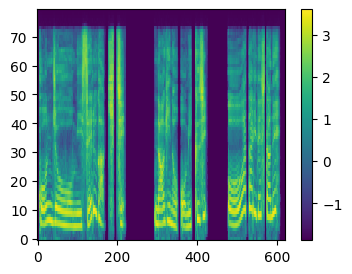

In [16]:
import matplotlib

import matplotlib.pylab as plt
import torchaudio

def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    fig.canvas.draw()
    plt.close()

    return fig

to_mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=48000,
    n_mels=80, n_fft=2048, win_length=2048, hop_length=512)
mean, std = -4, 4

def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

audio = preprocess(audio.cpu().numpy())

audio = audio.squeeze(0)

plot_spectrogram(audio.squeeze(0).cpu().numpy())

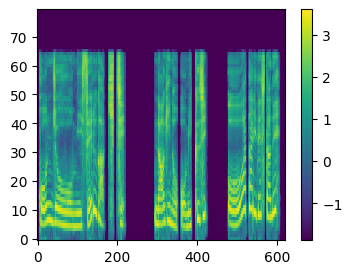

In [125]:
en = preprocess(audios)
plot_spectrogram(en.squeeze(0).squeeze(0).cpu().numpy())

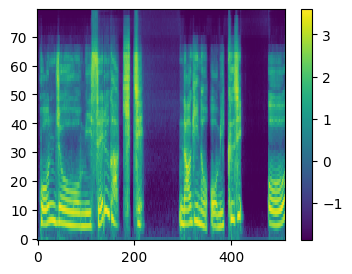

In [10]:
en = preprocess(enhanced.cpu().numpy())
plot_spectrogram(en.squeeze(0).squeeze(0).cpu().numpy())

In [5]:
# Download and open some audio file. You use your audio files here
audio_path = "/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/ckpts_subset_diff_upsample/test_generated_sound_102500_nagi_voice_301290_6_06.wav"
audio, _ = load_audio(audio_path, sr=df_state.sr())
# Denoise the audio
enhanced = enhance(model, df_state, audio)
# Save for listening
print("48_rec")
Audio(enhanced, rate=df_state.sr())

48_rec


NameError: name 'Audio' is not defined

In [51]:
Audio(audio, rate=df_state.sr())

# rest

In [17]:
import h5py
import numpy as np
from IPython.display import Audio

# Load the HDF5 file
hdf5_file = "/home/austin/disk2/llmvcs/tt/deepfilter/deepfilternet/DeepFilterNet/VALID_SET_NOISE.hdf5"
with h5py.File(hdf5_file, 'r') as f:
    # Navigate to the 'noise' group
    noise_group = f['noise']
    
    # Assuming you want to play the first dataset in the 'noise' group
    first_dataset_name = list(noise_group.keys())[-1]
    first_dataset = noise_group[first_dataset_name]
    
    # Extract the audio data
    audio_data = first_dataset[0]  # Extract the first sample
    sample_rate = 48000  # Assuming the sample rate is 48 kHz

# Play the audio in the Jupyter Notebook
Audio(audio_data, rate=sample_rate)

In [8]:
import os
import shutil
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
# Define the input and output directories
input_file = '/home/austin/disk1/stts-zs_cleaning/data/puckysamples_subset.csv'
output_dir = '/home/austin/disk1/stts-zs_cleaning/data/reconstructer_set'

# Create the necessary subdirectories
train_clean_dir = os.path.join(output_dir, 'train', 'clean')
train_noisy_dir = os.path.join(output_dir, 'train', 'noisy')
valid_clean_dir = os.path.join(output_dir, 'valid', 'clean')
valid_noisy_dir = os.path.join(output_dir, 'valid', 'noisy')

os.makedirs(train_clean_dir, exist_ok=True)
os.makedirs(train_noisy_dir, exist_ok=True)
os.makedirs(valid_clean_dir, exist_ok=True)
os.makedirs(valid_noisy_dir, exist_ok=True)

# Load the input data using Pandas
data = pd.read_csv(input_file, sep='|', header=None)

# Keep track of the unique filenames
unique_filenames = defaultdict(int)

# Iterate over the data and rename the files
for _, row in tqdm(data.iterrows()):
    clean_path, noisy_path = row[0], row[1]
    
    # Construct the new filenames
    unique_id = unique_filenames['filename']
    unique_filenames['filename'] += 1
    
    clean_filename = f"filename_{unique_id}_clean.wav"
    noisy_filename = f"filename_{unique_id}_noisy.wav"
    
    # Determine the output directories based on the split
    if unique_id < int(len(unique_filenames) * 0.998):
        clean_output_dir = train_clean_dir
        noisy_output_dir = train_noisy_dir
    else:
        clean_output_dir = valid_clean_dir
        noisy_output_dir = valid_noisy_dir
    
    # Copy the files to the appropriate directories
    clean_output_path = os.path.join(clean_output_dir, clean_filename)
    noisy_output_path = os.path.join(noisy_output_dir, noisy_filename)
    
    shutil.copy(clean_path, clean_output_path)
    shutil.copy(noisy_path, noisy_output_path)

print('Data preparation complete!')

13953it [00:16, 825.93it/s]


KeyboardInterrupt: 

In [118]:
import pandas as pd
df = pd.read_csv("/home/austin/disk1/stts-zs_cleaning/data/puckysamples_subset.csv", sep="|", header=None)

In [1]:
import shutil
shutil.rmtree("/home/austin/disk1/stts-zs_cleaning/audiotools/data")
shutil.rmtree("/home/austin/disk1/stts-zs_cleaning/data/reconstructer_set/valid")

In [51]:
from audiomentations import *
import numpy as np
import librosa
from IPython.display import Audio as ad

# Load the audio file
audio, sr = librosa.load("/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/samps/syuukovoice_200918_3_01.wav", sr=48000)

audio = librosa.resample(audio, orig_sr=sr, target_sr=24000)
sr = 24000
# Define the augmentation pipeline
augment = Compose([
    # BitCrush(p=1., min_bit_depth=3,max_bit_depth=4),
    Mp3Compression(p=1, min_bitrate=32, max_bitrate=32)
])

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=audio, sample_rate=sr)

# Play the augmented audio (assuming `ad` is a function to play audio)
ad(augmented_samples, rate=sr)

In [3]:
import os
import shutil
from pathlib import Path

def copy_audio_files(df, destination_base):
    # Create the destination base directory if it doesn't exist
    Path(destination_base).mkdir(parents=True, exist_ok=True)
    
    # Get the column name of the first column (assuming it contains the paths)
    path_column = df.columns[0]
    
    # Process each file path
    for file_path in df[path_column]:
        # Convert string path to Path object
        src_path = Path(file_path)
        
        # Find the index of 'moe_soshy' in the parts
        parts = src_path.parts
        try:
            start_idx = parts.index('moe_soshy')
        except ValueError:
            print(f"Warning: 'moe_soshy' not found in path: {file_path}")
            continue
        
        # Get the relative path starting from 'moe_soshy'
        relative_path = os.path.join(*parts[start_idx:])
        
        # Create the destination path
        dest_path = Path(destination_base) / relative_path
        
        # Create parent directories if they don't exist
        dest_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Copy the file
        try:
            shutil.copy2(src_path, dest_path)
            # print(f"Copied: {dest_path}")
        except Exception as e:
            print(f"Error copying {src_path}: {e}")

# Use the function
destination_path = "/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/data_noise/kasif/"
copy_audio_files(df, destination_path)

In [80]:
from collections import defaultdict

# df2 = df2.drop(3,axis=1)
speaker_to_id = defaultdict(lambda: len(speaker_to_id))

df3[3] = df3[2].apply(lambda x: int(speaker_to_id[x])) 


In [10]:
import pandas as pd
df = pd.read_csv("/home/austin/disk1/stts-zs_cleaning/data/train_List_updated_plus_reID_48khz.csv", sep='|', header=None)
# df = df.sample(df.shape[0])
# df.to_csv("/home/austin/disk2/llmvcs/tt/stylekan/Data/mg_valid.csv",sep="|",header=False, index=False)
df.shape

(524711, 4)

In [11]:
df.head()

0  \
0  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
1  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
2  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
3  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
4  /home/austin/disk1/stts-zs_cleaning/data/moe_s...   

                                                   1          2  3  
0                             a, sonna koto mo aʔta.   338ab306  0  
1  soto niːte mo ɕikatanai desɯɕi, itsɯ mo ie de,...   282cfa8c  1  
2  biːzɯ no bɯbɯɴ ga, kaiteɴ sɯrɯ ɕikɯmi ni naʔte...   4cb40d9c  2  
3              gohaɴ o okawaɽi ɕitɕaʔte mo, desɯ ka?   00013899  3  
4  sonna , modʑi toːɽi akɯɕɯmi na koɽekɯɕoɴ ni te...  horie_yui  4

In [17]:
df['column2'].str.contains('ᵻ').any()

False

In [12]:
# import pandas as pd
# import librosa
# from tqdm import tqdm

# name ="/home/austin/disk2/llmvcs/tt/stylekan/Data/train_List_updated.csv"
# df = pd.read_csv(name, sep="|", header=None)
# # df = df.drop_duplicates(subset=['filename'])
# # df = df.dropna()
# # Assuming df is your dataframe
# def filter_short_audio(df):
#     def is_long_enough(file_path):
#         duration = librosa.get_duration(filename=file_path)
#         return duration >= 1.5

#     tqdm.pandas(desc="Processing audio files")
#     return df[df[0].progress_apply(is_long_enough)]

# # Example usage
# # df = pd.read_csv('your_dataframe.csv')
# filtered_df = filter_short_audio(df)
# print("filetered:\n", filtered_df.shape)
# print("OG:\n", df.shape)
# df = filtered_df

import pandas as pd
import librosa
from datasets import Dataset
from tqdm.auto import tqdm
import multiprocessing as mp

def is_long_enough(file_path):
    try:
        duration = librosa.get_duration(filename=file_path)
        return duration >= 1.5
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return False

def filter_short_audio(examples):
    return {
        'is_long_enough': [is_long_enough(path) for path in examples['file_path']]
    }

# Load the CSV file
name = "/home/austin/disk1/stts-zs_cleaning/data/train_List_updated_plus_reID_48khz.csv"
df = pd.read_csv(name, sep="|", header=None, names=['file_path', 'column2', 'column3','idsss'])

print("Original DataFrame shape:", df.shape)

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Set up multiprocessing
num_cores = 64 # Use all available cores

# Apply the filtering function to the dataset
filtered_dataset = dataset.map(
    filter_short_audio,
    batched=True,
    num_proc=num_cores,
    desc="Processing audio files",
)

# Filter out short audio files
filtered_dataset = filtered_dataset.filter(lambda example: example['is_long_enough'])

# Convert back to pandas DataFrame and drop the 'is_long_enough' column
df = filtered_dataset.remove_columns(['is_long_enough']).to_pandas()

print("Filtered DataFrame shape:", df.shape)

# Display the first few rows of the filtered dataframe
df.head()

# Optional: Save the filtered dataframe to a new CSV file
# filtered_df.to_csv('filtered_audio_list.csv', index=False, sep='|')

Original DataFrame shape: (524711, 4)


Processing audio files (num_proc=64):   0%|          | 0/524711 [00:00<?, ? examples/s]

/tmp/ipykernel_1557929/1137896345.py:33: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path)
/tmp/ipykernel_1557929/1137896345.py:33: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path)
/tmp/ipykernel_1557929/1137896345.py:33: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path)
/tmp/ipykernel_1557929/1137896345.py:33: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path)
/tmp/ipykernel_1557929/11378

Filter:   0%|          | 0/524711 [00:00<?, ? examples/s]

Filtered DataFrame shape: (519794, 4)


file_path  \
0  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
1  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
2  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
3  /home/austin/disk1/stts-zs_cleaning/data/moe_4...   
4  /home/austin/disk1/stts-zs_cleaning/data/moe_s...   

                                             column2    column3  idsss  
0                             a, sonna koto mo aʔta.   338ab306      0  
1  soto niːte mo ɕikatanai desɯɕi, itsɯ mo ie de,...   282cfa8c      1  
2  biːzɯ no bɯbɯɴ ga, kaiteɴ sɯrɯ ɕikɯmi ni naʔte...   4cb40d9c      2  
3              gohaɴ o okawaɽi ɕitɕaʔte mo, desɯ ka?   00013899      3  
4  sonna , modʑi toːɽi akɯɕɯmi na koɽekɯɕoɴ ni te...  horie_yui      4

In [18]:
df.to_csv("/home/austin/disk1/stts-zs_cleaning/data/PREPROCESSED_train_List_updated_plus_reID_48khz.csv",sep="|",header=False, index=False)

In [23]:
import os
import pandas as pd
from datasets import Dataset
# Initialize an empty list to store the full paths of the .wav files
wav_files = []

for root, dirs, files in os.walk("/home/austin/disk1/stts-zs_cleaning/audio-diffusion-pytorch/data_noise/kasif/subset"):
    for file in files:
        # Check if the file is a .wav file
        if file.endswith(".wav"):
            # Construct the full path and add it to the list
            full_path = os.path.join(root, file)
            wav_files.append(full_path)

# Create a pandas DataFrame from the list of full paths
df2 = pd.DataFrame(wav_files, columns=["wav_file_path"])
df2.shape

(59297, 1)

In [49]:


df = data.groupby(2).filter(lambda x: len(x) >= 120)
df.shape

(524711, 3)

In [1]:
import pandas as pd
from pydub import AudioSegment
from tqdm import tqdm
# Load the CSV file
df = pd.read_csv('/home/austin/disk2/llmvcs/tt/stylekan/Data/metadata_cleanest/train_48_pure.csv', sep="|", header=None)

# Initialize total duration
total_duration = 0

# Iterate over each audio file path in the first column
for audio_path in tqdm(df.iloc[:, 0]):
    # Load the audio file
    audio = AudioSegment.from_file(audio_path)
    # Add the duration of the audio file to the total duration
    total_duration += len(audio)

# Convert total duration from milliseconds to hours
total_hours = total_duration / (1000 * 60 * 60)

print(f"{total_hours:.2f} hours")

100%|██████████| 211854/211854 [00:33<00:00, 6383.35it/s]

330.95 hours


In [98]:
import pandas as pd
import re

df = pd.read_csv('/home/austin/disk2/llmvcs/tt/AuxiliaryASR/Data/train_list_subsection.csv', sep='|', header=None)

def has_repeated_sequence(s, repeat_threshold=3, portion_threshold=0.5):
    # Tokenize the sentence into words
    words = s.split()
    length = len(words)
    
    # A dictionary to store sequences and their counts
    sequence_counts = {}
    
    # Check all possible sequences but limit the size to avoid complexity
    max_seq_length = min(5, length // 2)  # For example, 5 as max length for subsequence to check
    
    for seq_length in range(1, max_seq_length + 1):
        for i in range(length - seq_length + 1):
            sequence = tuple(words[i:i + seq_length])
            if sequence not in sequence_counts:
                sequence_counts[sequence] = 0
            sequence_counts[sequence] += 1
    
    # Determine if any repeating sequence meets the criteria
    for sequence, count in sequence_counts.items():
        if count >= repeat_threshold and (count * len(sequence)) / length > portion_threshold:
            return True
    
    return False

# Filter rows with a repeated pattern in the second column (index 1)
pattern_rows = df[df[1].apply(has_repeated_sequence)]

# Create a new DataFrame with the filtered rows
df2 = pattern_rows.copy()

# Optionally, reset the index of the new DataFrame
df2.reset_index(drop=True, inplace=True)

# Print the resulting DataFrame
df2.shape

(24, 3)

In [118]:
import pandas as pd

# Define the paths to the CSV files
hallucinate_path = '/home/austin/disk2/llmvcs/tt/cotlet/hallucinate.csv'
train_list_path = '/home/austin/disk2/llmvcs/tt/stylekan/Data/train_List.csv'


# Load the CSV files into DataFrames
hallucinate_df = pd.read_csv(hallucinate_path, header=None, sep="|")
train_list_df = pd.read_csv(train_list_path, sep="|", header=None)

# Assuming the filenames are in the first column of both DataFrames
corrupted_filenames = set(hallucinate_df[1])

# Filter out the corrupted filenames from the main data
cleaned_train_list_df = train_list_df[~train_list_df[1].isin(corrupted_filenames)]
cleaned_train_list_df.reset_index(drop=True, inplace=True)
# # Save the cleaned data to a new CSV file
cleaned_train_list_df.to_csv(train_list_path, sep="|", index=False, header=None)
cleaned_train_list_df.shape

(525540, 3)

In [2]:
import os
import datetime

def get_modification_date(file_path):

    mod_time = os.path.getmtime(file_path)
    return datetime.datetime.fromtimestamp(mod_time)

def list_files_with_modification_dates(directory):

    for root, dirs, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith('.pth'):
                file_path = os.path.join(root, file_name)
                mod_date = get_modification_date(file_path)
                print(f"File: {file_path} | Modified on: {mod_date}")

if __name__ == "__main__":
    directory_path = "/home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade"
    list_files_with_modification_dates(directory_path)

File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/succ_epoch_2nd_00002.pth | Modified on: 2024-10-05 07:34:07.563425
File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/epoch_2nd_00001.pth | Modified on: 2024-10-04 12:41:09.543483
File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/2nd_phase_51745.pth | Modified on: 2024-10-14 17:39:48.346199
File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/2nd_phase_53945.pth | Modified on: 2024-10-14 20:31:06.624946
File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/epoch_2nd_00000.pth | Modified on: 2024-10-02 02:05:11.827047
File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/succ_2nd_phase_60545.pth | Modified on: 2024-10-15 06:15:02.589877
File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/2nd_phase_72645.pth | Modified on: 2024-10-14 12:05:57.093188
File: /home/austin/disk2/llmvcs/tt/stylekan/Models/Style_Kanade/epoch_1st_00013.pth | Modified on: 2024-09-3